In [1]:
# importing necessay libraries and modules
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

# Preparing Heterogeneous Dataset

In [2]:
class heterogeneous_dataset:
    def __init__(self, n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25):
        self.n_samples_train = n_samples_train
        self.n_samples_test = n_samples_test
        self.n_clients = n_clients
        self.batch_size = batch_size

    def _split_digits(self, shuffle_digits=False):
        # function to split digits into groups for clients
        digits = torch.randperm(10) if shuffle_digits else torch.arange(10)

        digits_split = []
        start_idx = 0
        for n in range(self.n_clients, 0, -1):
            end_idx = start_idx + (10 - start_idx) // n
            digits_split.append(digits[start_idx:end_idx])
            start_idx = end_idx
            
        return digits_split

    def _load_dataset(self, train):
        # function to load MNIST dataset
        dataset = datasets.MNIST(root="./data", train=train, download=True, transform=transforms.ToTensor())
        return dataset

    def _create_data_loader(self, dataset):
        # function to create DataLoader and retrieve images and labels
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.n_clients * min(self.n_samples_train, self.n_samples_test), shuffle=True)
        images, labels = next(iter(loader))
        return images, labels

    def _split_data(self, images, labels, digits_split):
        # function to split data based on grouped digits
        data_splitted = []
        for digits_set in digits_split:
            idx = torch.any(torch.stack([labels == digit for digit in digits_set]), dim=0)
            data_splitted.append(torch.utils.data.DataLoader(
                torch.utils.data.TensorDataset(images[idx], labels[idx]), 
                batch_size=self.batch_size, shuffle=True
            ))
        return data_splitted

    def non_iid_split(self, dataset, shuffle_digits=False):
        # Function to perform non-IID split on the dataset
        assert 0 < self.n_clients <= 10
        digits_split = self._split_digits(shuffle_digits)
        images, labels = self._create_data_loader(dataset)
        return self._split_data(images, labels, digits_split)

    def get_MNIST(self, shuffle=True):
        # function to get non-IID split MNIST datasets for training and testing
        dataset_train = self._load_dataset(train=True)
        dataset_test = self._load_dataset(train=False)
        return self.non_iid_split(dataset_train, shuffle), self.non_iid_split(dataset_test, shuffle)

    def plot_data(self, data, channel: int, title=None, plot_name="", n_examples=20):
        # function to plot sample images from the dataset
        n_rows = int(n_examples / 5)
        plt.figure(figsize=(1 * n_rows, 1 * n_rows))
        if title:
            plt.suptitle(title)
        X, y = data
        for idx in range(n_examples):
            ax = plt.subplot(n_rows, 5, idx + 1)
            image = 255 - X[idx, channel].view((28, 28))
            ax.imshow(image, cmap='inferno_r')
            ax.axis("off")
            
        plt.tight_layout()

In [3]:
data = heterogeneous_dataset(n_samples_train=200, n_samples_test=100, n_clients=5, batch_size=25)

### Plotting the Data

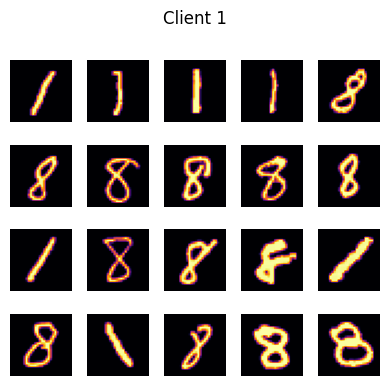

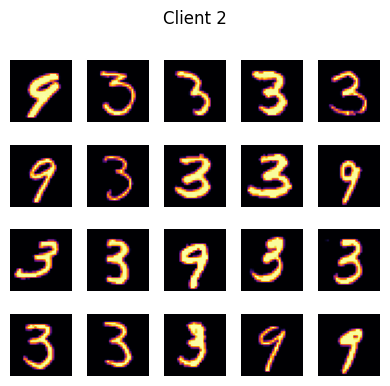

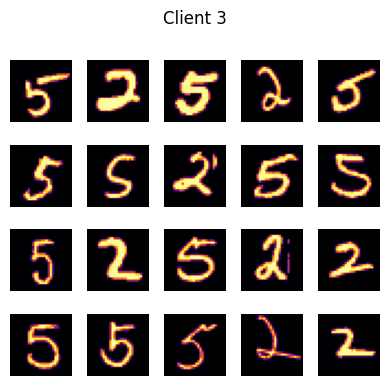

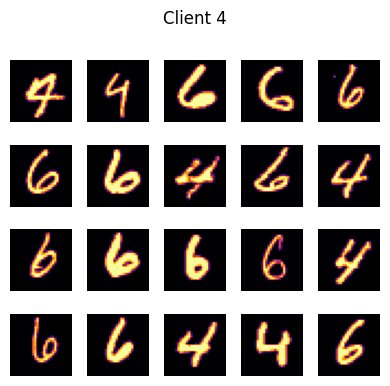

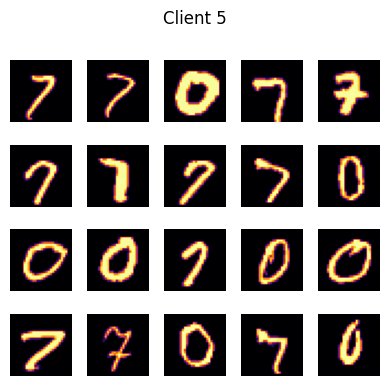

In [4]:
train_data, test_data = data.get_MNIST()
data.plot_data(next(iter(train_data[0])), channel=0, title="Client 1")
data.plot_data(next(iter(train_data[1])), channel=0, title="Client 2")
data.plot_data(next(iter(train_data[2])), channel=0, title="Client 3")
data.plot_data(next(iter(train_data[3])), channel=0, title="Client 4")
data.plot_data(next(iter(train_data[4])), channel=0, title="Client 5")

# Main Server Model

In [5]:
class CNN(nn.Module):
    """ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(20, 50, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(4 * 4 * 50, 500),
            nn.ReLU(),
            nn.Linear(500, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 4 * 4 * 50)
        x = self.classifier(x)
        return x

In [6]:
model = CNN()

### Loss & Accuracy Calculation

In [7]:
class LossAndAccuracyAnalysis:
    def __init__(self):
        self.loss_fn = nn.NLLLoss(reduction="mean")
        self.log_softmax = nn.LogSoftmax(dim=1)

    def loss(self, model, dataset, mu=0, model_0=None):
        total_loss = 0
        for features, labels in dataset:
            predictions = model(features)
            loss = self.loss_fn(self.log_softmax(predictions), labels.view(-1))
            if model_0 is not None:
                loss += mu / 2 * self.difference_models_norm_2(model, model_0)
            total_loss += loss
        return total_loss / len(dataset)

    def accuracy(self, model, dataset):
        correct = 0
        for features, labels in dataset:
            predictions = model(features)
            _, predicted = predictions.max(1, keepdim=True)
            correct += torch.sum(predicted.view(-1, 1) == labels.view(-1, 1)).item()
        return 100 * correct / len(dataset.dataset)

    def train_and_update(self, model, model_0, mu, optimizer, train_data, epochs):
        for _ in range(epochs):
            optimizer.zero_grad()
            loss = self.loss(model, train_data, mu, model_0)
            loss.backward()
            optimizer.step()
        return self.loss(model, train_data, mu, model_0).item()

    def local_learning(self, model, mu, optimizer, train_data, epochs):
        model_0 = deepcopy(model)
        losses = [self.train_and_update(model, model_0, mu, optimizer, train_data, 1) for _ in range(epochs)]
        return sum(losses) / len(losses)
    
    def local_learning_sgd(self, model, mu, optimizer, train_data, epochs):
        model_0 = deepcopy(model)
        for _ in range(epochs):
            for features, labels in train_data:
                optimizer.zero_grad()
                loss = self.loss(model, [(features, labels)], mu, model_0)
                loss.backward()
                optimizer.step()
        losses = [self.loss(model, train_data, mu, model_0) for _ in range(epochs)]
        return sum(losses) / len(losses)

    def difference_models_norm_2(self, model_1, model_2):
        return sum(torch.sum((p1 - p2) ** 2) for p1, p2 in zip(model_1.parameters(), model_2.parameters()))

    def set_to_zero_model_weights(self, model):
        for param in model.parameters():
            param.data.zero_()

# Federated Averaging (FedAvg)

In [8]:
class FedAvg:
    def __init__(self, model, training_sets, testing_sets, epochs=5, lr=1e-2, decay=1):
        self.model = model
        self.training_sets = training_sets
        self.testing_sets = testing_sets
        self.epochs = epochs
        self.lr = lr
        self.decay = decay
        self.loss_and_accuracy_analysis = LossAndAccuracyAnalysis()

        self.K = len(training_sets)  # number of clients
        self.n_samples = sum([len(db.dataset) for db in training_sets])
        self.weights = [len(db.dataset) / self.n_samples for db in training_sets]
        print("Clients' weights:", self.weights)
    
        self.loss_hist = [[float(self.loss_and_accuracy_analysis.loss(self.model, dl).detach()) for dl in training_sets]]
        self.acc_hist = [[self.loss_and_accuracy_analysis.accuracy(self.model, dl) for dl in testing_sets]]
        self.server_hist = [[tens_param.detach().numpy() for tens_param in list(self.model.parameters())]]

    def average_models(self, clients_models_hist):
        new_model = deepcopy(self.model)
        self.loss_and_accuracy_analysis.set_to_zero_model_weights(new_model)
        for k, client_hist in enumerate(clients_models_hist):
            for idx, layer_weights in enumerate(new_model.parameters()):
                contribution = client_hist[idx].data * self.weights[k]
                layer_weights.data.add_(contribution)
        return new_model

    def train(self, n_iter):
        for i in range(n_iter):
            clients_params = []
            clients_models = []
            clients_losses = []
            for k in range(self.K):
                local_model = deepcopy(self.model)
                local_optimizer = optim.SGD(local_model.parameters(), lr=self.lr)
                local_loss = self.loss_and_accuracy_analysis.local_learning(local_model, 0, local_optimizer, self.training_sets[k], self.epochs)
                clients_losses.append(local_loss)
                clients_params.append([tens_param.detach() for tens_param in list(local_model.parameters())])
                clients_models.append(deepcopy(local_model))

            self.model = self.average_models(clients_params)
            self.loss_hist += [[float(self.loss_and_accuracy_analysis.loss(self.model, dl).detach()) for dl in self.training_sets]]
            self.acc_hist += [[self.loss_and_accuracy_analysis.accuracy(self.model, dl) for dl in self.testing_sets]]
            self.server_hist.append([tens_param.detach().cpu().numpy() for tens_param in list(self.model.parameters())])

            server_loss = sum([self.weights[i] * self.loss_hist[-1][i] for i in range(len(self.weights))])
            server_acc = sum([self.weights[i] * self.acc_hist[-1][i] for i in range(len(self.weights))])
            print(f'Iteration: {i+1} Server Loss: {server_loss} Server Test Accuracy: {server_acc}')

            self.lr *= self.decay

        return self.model, self.loss_hist, self.acc_hist

# Federated Proximal Optimization (FedProx)

In [9]:
class FedProx(FedAvg):
    def __init__(self, model, training_sets, testing_sets, mu=0, epochs=5, lr=1e-2, decay=1):
        super().__init__(model, training_sets, testing_sets, epochs, lr, decay)
        self.mu = mu

    def train(self, n_iter):
        for i in range(n_iter):
            clients_params = []
            clients_models = []
            clients_losses = []
            for k in range(self.K):
                local_model = deepcopy(self.model)
                local_optimizer = optim.SGD(local_model.parameters(), lr=self.lr)
                local_loss = self.loss_and_accuracy_analysis.local_learning(local_model, self.mu, local_optimizer, self.training_sets[k], self.epochs)
                clients_losses.append(local_loss)
                clients_params.append([tens_param.detach() for tens_param in list(local_model.parameters())])
                clients_models.append(deepcopy(local_model))

            self.model = self.average_models(clients_params)
            self.loss_hist += [[float(self.loss_and_accuracy_analysis.loss(self.model, dl, self.mu).detach()) for dl in self.training_sets]]
            self.acc_hist += [[self.loss_and_accuracy_analysis.accuracy(self.model, dl) for dl in self.testing_sets]]
            self.server_hist.append([tens_param.detach().cpu().numpy() for tens_param in list(self.model.parameters())])

            server_loss = sum([self.weights[i] * self.loss_hist[-1][i] for i in range(len(self.weights))])
            server_acc = sum([self.weights[i] * self.acc_hist[-1][i] for i in range(len(self.weights))])
            print(f'Iteration: {i+1} Server Loss: {server_loss} Server Test Accuracy: {server_acc}')

            self.lr *= self.decay

        return self.model, self.loss_hist, self.acc_hist

# Federated Stocastic Gradient Descent (FedSGD)

In [10]:
class FedSGD(FedAvg):
    def __init__(self, model, training_sets, testing_sets, epochs=5, lr=1e-2, decay=1):
        super().__init__(model, training_sets, testing_sets, epochs, lr, decay)

    def train(self, n_iter):
        for i in range(n_iter):
            clients_params = []
            clients_models = []
            clients_losses = []
            for k in range(self.K):
                local_model = deepcopy(self.model)
                local_optimizer = optim.SGD(local_model.parameters(), lr=self.lr)
                local_loss = self.loss_and_accuracy_analysis.local_learning_sgd(local_model, 0, local_optimizer, self.training_sets[k], self.epochs)
                clients_losses.append(local_loss)
                clients_params.append([tens_param.detach() for tens_param in list(local_model.parameters())])
                clients_models.append(deepcopy(local_model))

            self.model = self.average_models(clients_params)
            self.loss_hist += [[float(self.loss_and_accuracy_analysis.loss(self.model, dl).detach()) for dl in self.training_sets]]
            self.acc_hist += [[self.loss_and_accuracy_analysis.accuracy(self.model, dl) for dl in self.testing_sets]]
            self.server_hist.append([tens_param.detach().cpu().numpy() for tens_param in list(self.model.parameters())])

            server_loss = sum([self.weights[i] * self.loss_hist[-1][i] for i in range(len(self.weights))])
            server_acc = sum([self.weights[i] * self.acc_hist[-1][i] for i in range(len(self.weights))])
            print(f'Iteration: {i+1} Server Loss: {server_loss} Server Test Accuracy: {server_acc}')

            self.lr *= self.decay

        return self.model, self.loss_hist, self.acc_hist

# Plotting training loss and testing accuracy curves over the iterations

In [11]:
def plot(title, loss_hist, acc_hist):
    plt.figure(figsize=(20,6)) 
    
    plt.suptitle(title)

    plt.subplot(1,2,1)
    lines=plt.plot(loss_hist)
    plt.title("Loss")
    plt.legend(lines,["Client1", "Client2", "Client3", "Client4", "Client5"])

    plt.subplot(1,2,2)
    lines=plt.plot(acc_hist)
    plt.title("Accuracy")
    plt.legend(lines, ["Client1", "Client2", "Client3", "Client4", "Client5"])

In [12]:
def plot_test(model, test_client, client_number):
    # set the model to evaluation mode
    model.eval()

    # prepare lists to store images, true labels, and predicted labels
    images_list = []
    true_labels_list = []
    predicted_labels_list = []

    # iterate over the test data and make predictions
    for images, labels in test_client:
        # forward pass
        predictions = model_fedavg(images)
        _, predicted_labels = predictions.max(1)

        # convert tensors to numpy arrays
        images = images.numpy()
        labels = labels.numpy()
        predicted_labels = predicted_labels.numpy()

        # append to lists
        images_list.append(images)
        true_labels_list.append(labels)
        predicted_labels_list.append(predicted_labels)

    # concatenate the lists to form single numpy arrays
    images_array = np.concatenate(images_list, axis=0)
    true_labels_array = np.concatenate(true_labels_list, axis=0)
    predicted_labels_array = np.concatenate(predicted_labels_list, axis=0)

    # plot a subset of the test images along with their true and predicted labels
    n_examples = min(20, len(images_array))  # limit the number of examples to 20
    n_rows = int(np.ceil(n_examples / 5))  # calculate the number of rows, ensuring it's at least 1

    plt.figure(figsize=(2.5 * n_rows, 5))
    for idx in range(n_examples):
        ax = plt.subplot(n_rows, 5, idx + 1)
        image = 255 - images_array[idx, 0]  # assuming images are grayscale
        ax.imshow(image, cmap='inferno_r')
        if true_labels_array[idx] != predicted_labels_array[idx]:
            ax.set_title(f'True: {true_labels_array[idx]}, Predicted: {predicted_labels_array[idx]}', fontsize=10, color='orangered')
        else:
            ax.set_title(f'True: {true_labels_array[idx]}, Predicted: {predicted_labels_array[idx]}', fontsize=10, color='lightseagreen')
        ax.axis("off")
    
    plt.suptitle(f"Client {client_number}")
    plt.tight_layout()
    plt.show()

# Training using FedAvg
---

In [13]:
n_iter=40
FedAvg = FedAvg(model, train_data, test_data, 2, 0.1)
model_fedavg, loss_fedavg, acc_fedavg = FedAvg.train(n_iter)

Clients' weights: [0.2, 0.214, 0.198, 0.198, 0.19]
Iteration: 1 Server Loss: 2.296389572620392 Server Test Accuracy: 9.412371134020619
Iteration: 2 Server Loss: 2.2841355476379395 Server Test Accuracy: 9.0
Iteration: 3 Server Loss: 2.265676501750946 Server Test Accuracy: 9.0
Iteration: 4 Server Loss: 2.2417450466156006 Server Test Accuracy: 9.0
Iteration: 5 Server Loss: 2.2671600189208987 Server Test Accuracy: 10.952383861998122
Iteration: 6 Server Loss: 2.2478815150260925 Server Test Accuracy: 17.61966110550272
Iteration: 7 Server Loss: 2.223596604824066 Server Test Accuracy: 20.15946283406833
Iteration: 8 Server Loss: 2.1703313822746275 Server Test Accuracy: 36.506155465188314
Iteration: 9 Server Loss: 2.168702218055725 Server Test Accuracy: 21.478130014345677
Iteration: 10 Server Loss: 2.080055510044098 Server Test Accuracy: 56.67565906037181
Iteration: 11 Server Loss: 2.036945709705353 Server Test Accuracy: 27.218141550045274
Iteration: 12 Server Loss: 2.0206957552433016 Server Tes

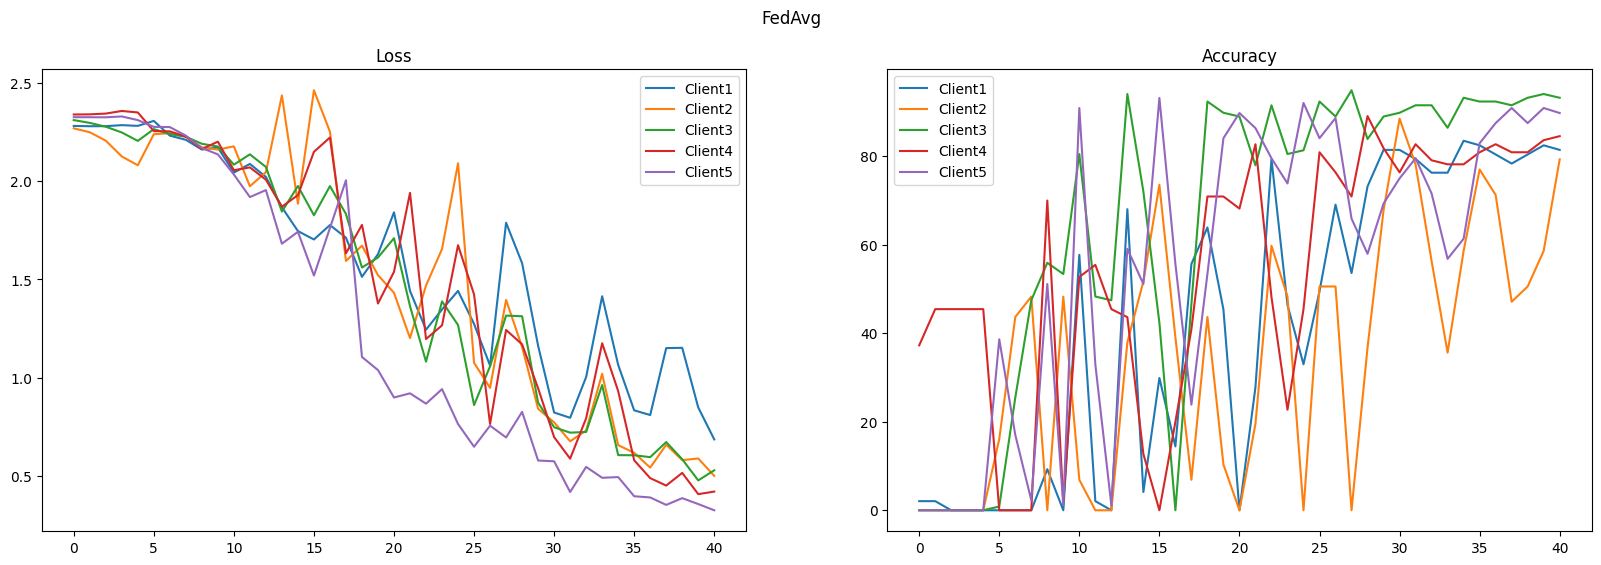

In [14]:
plot("FedAvg", loss_fedavg, acc_fedavg)

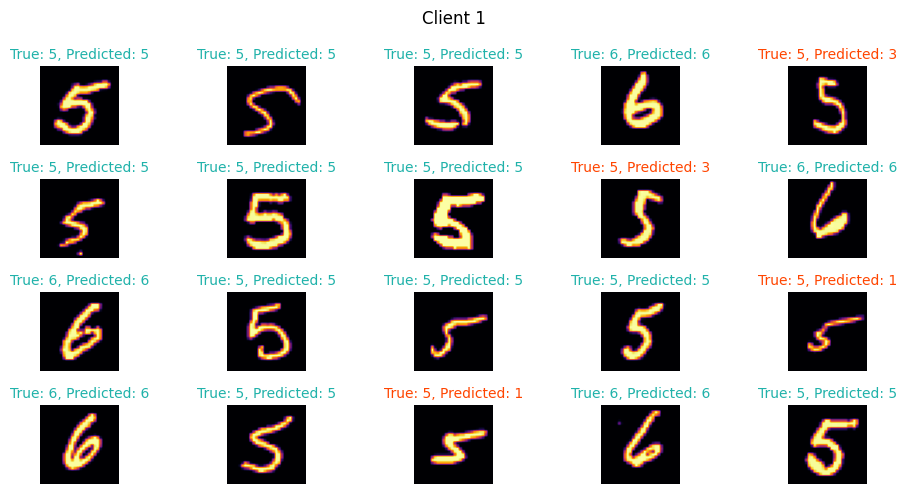

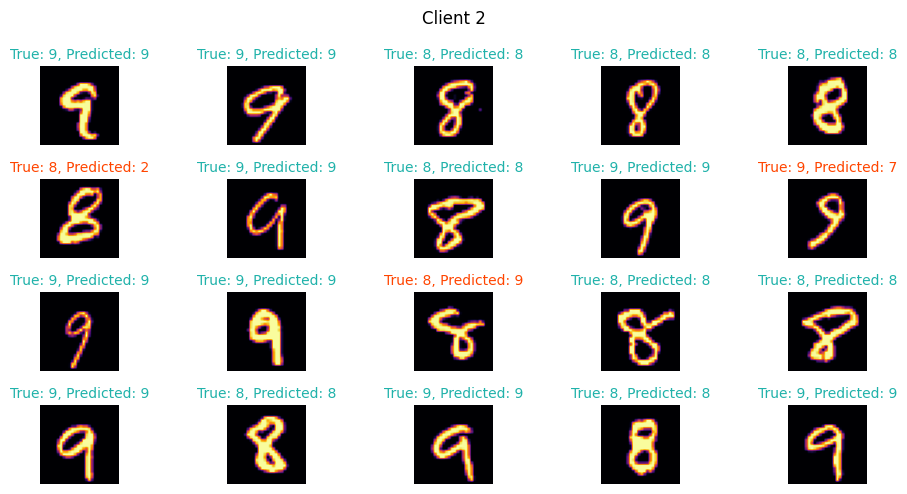

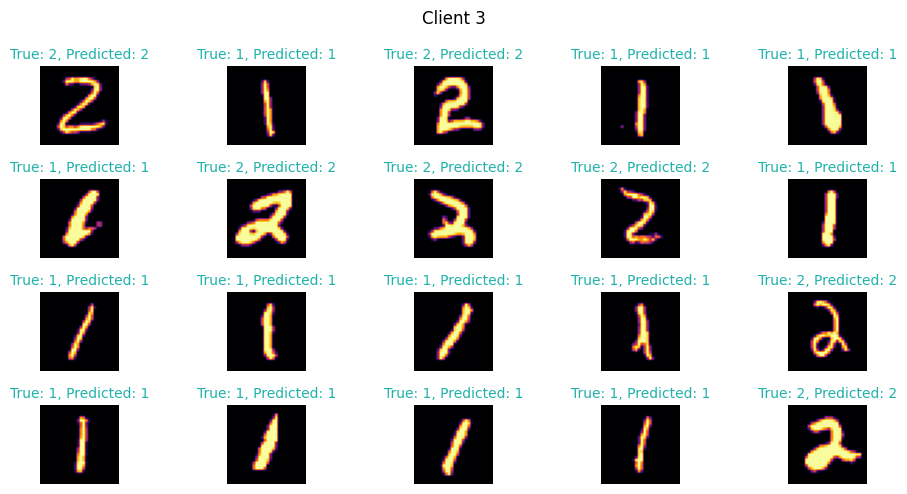

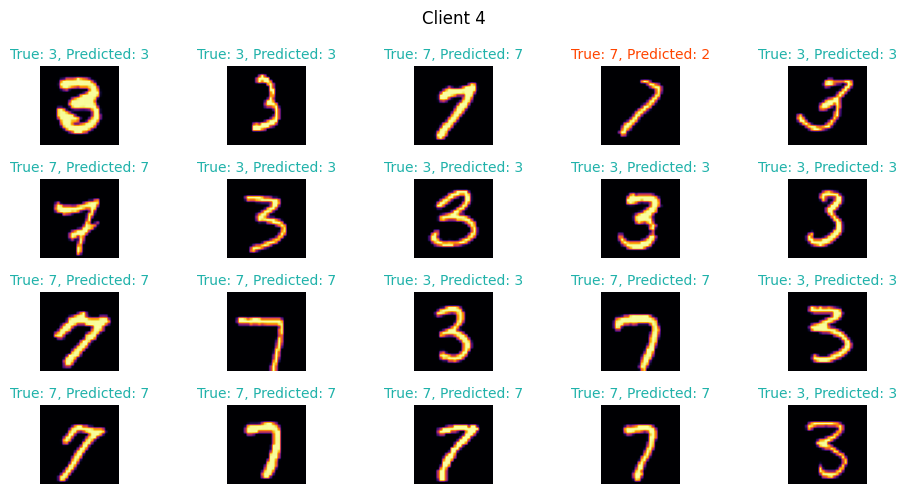

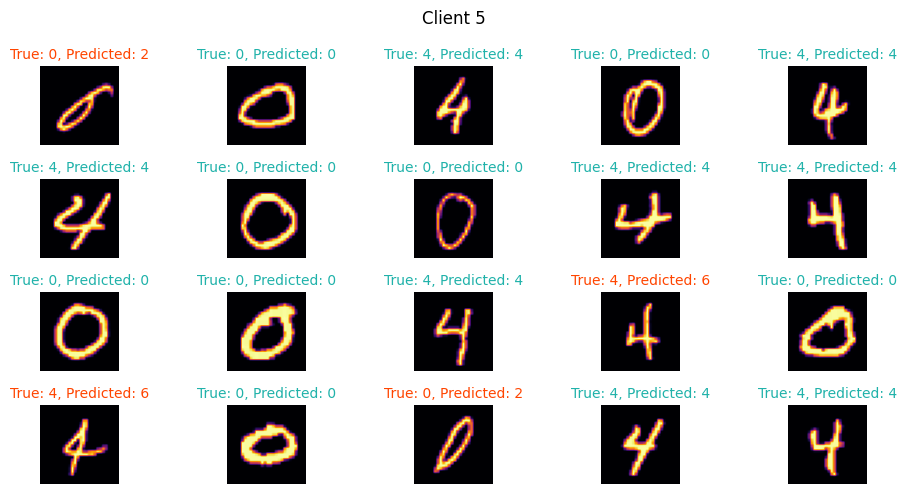

In [15]:
for client_number in range(5):
    plot_test(model_fedavg, test_data[client_number], client_number+1)

# Training using FedProx
---

In [16]:
n_iter=40
FedProx = FedProx(model, train_data, test_data, 0.2, 2, 0.1)
model_fedprox, loss_fedprox, acc_fedprox = FedProx.train(n_iter)

Clients' weights: [0.2, 0.214, 0.198, 0.198, 0.19]
Iteration: 1 Server Loss: 2.2957574019432068 Server Test Accuracy: 9.412371134020619
Iteration: 2 Server Loss: 2.284540186882019 Server Test Accuracy: 9.0
Iteration: 3 Server Loss: 2.2668366966247557 Server Test Accuracy: 9.0
Iteration: 4 Server Loss: 2.2457136626243592 Server Test Accuracy: 9.0
Iteration: 5 Server Loss: 2.265207132339478 Server Test Accuracy: 9.422160618458106
Iteration: 6 Server Loss: 2.237275218486786 Server Test Accuracy: 14.093645230860972
Iteration: 7 Server Loss: 2.2396730146408084 Server Test Accuracy: 20.111350353328728
Iteration: 8 Server Loss: 2.170661975860596 Server Test Accuracy: 37.11349649738694
Iteration: 9 Server Loss: 2.1401812100410464 Server Test Accuracy: 31.83828022492971
Iteration: 10 Server Loss: 2.1263375267982485 Server Test Accuracy: 20.734424313267095
Iteration: 11 Server Loss: 2.0265354645252227 Server Test Accuracy: 66.61982236519819
Iteration: 12 Server Loss: 1.9811022069454194 Server Te

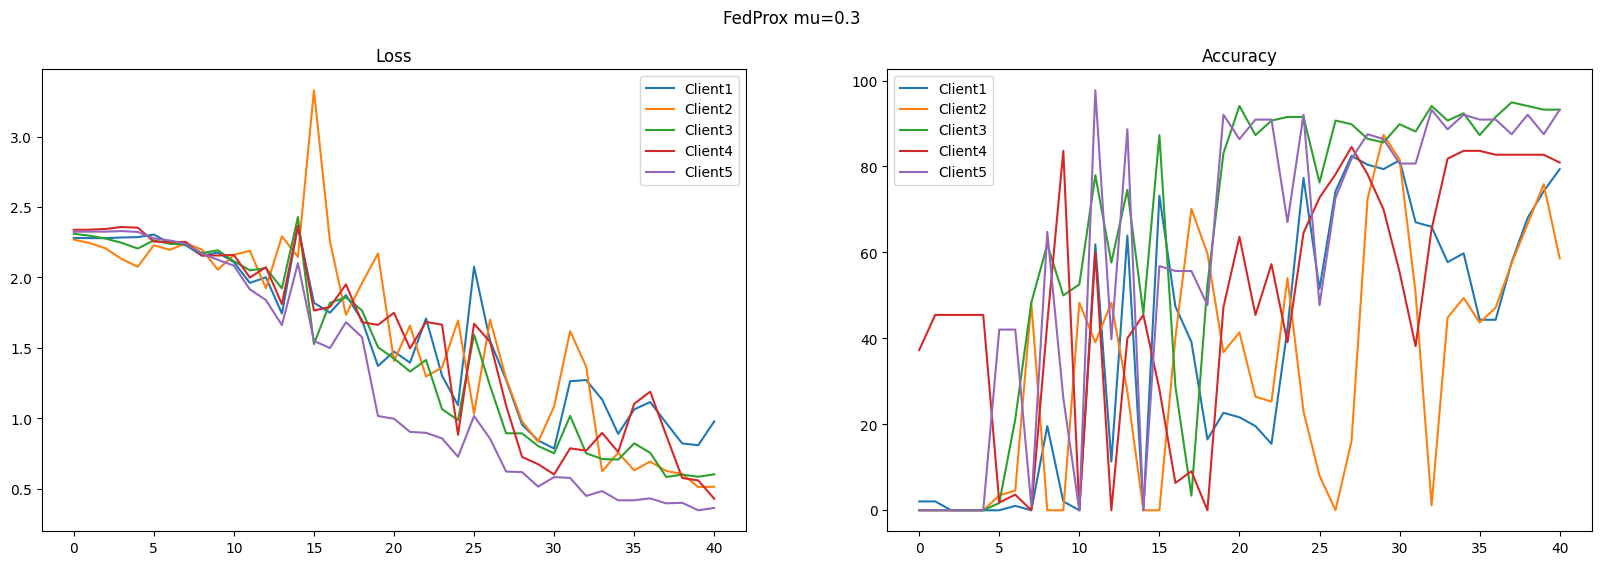

In [17]:
plot("FedProx mu=0.3", loss_fedprox, acc_fedprox)

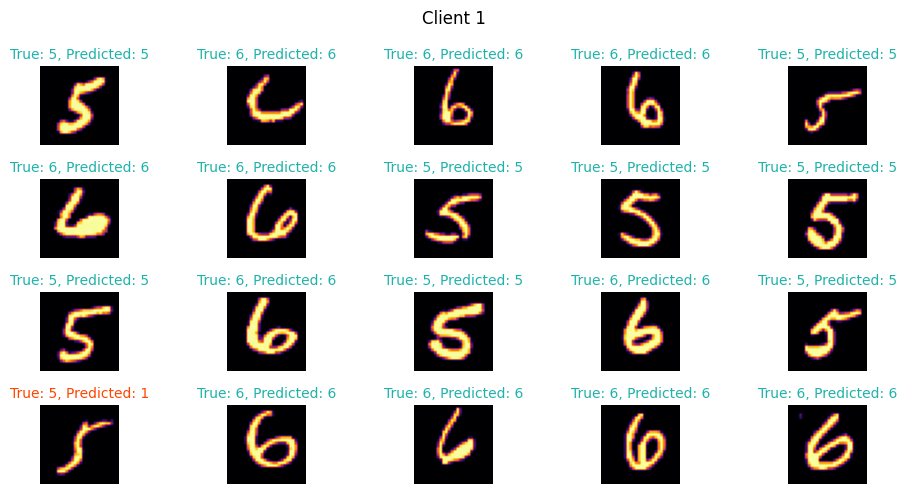

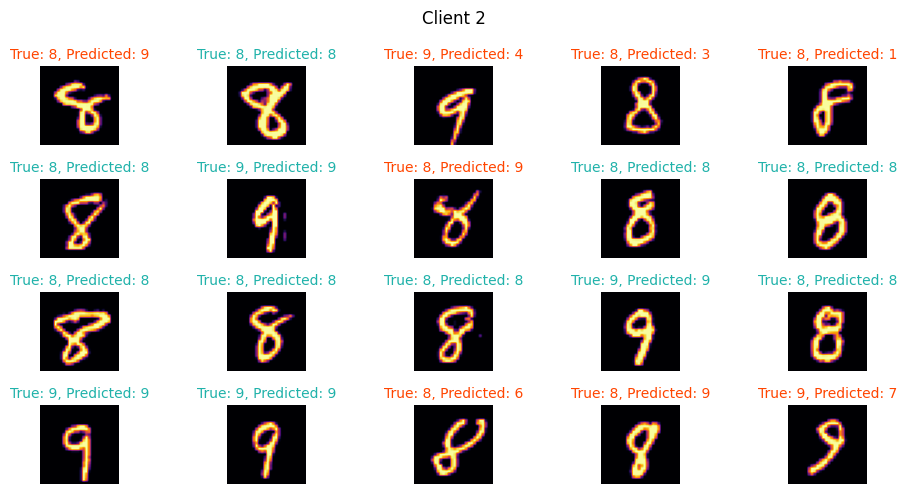

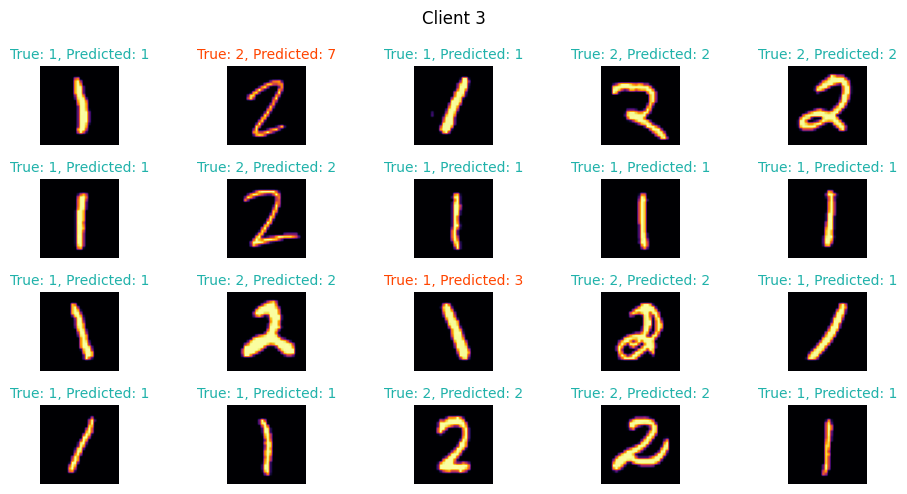

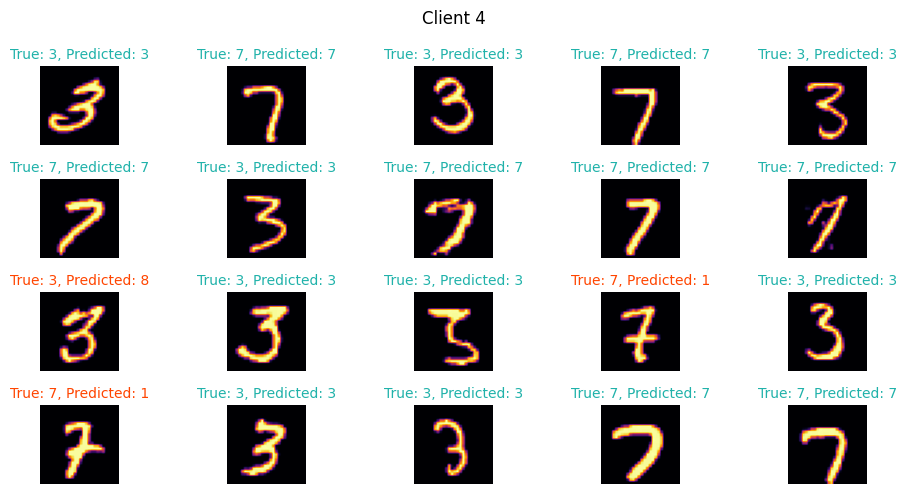

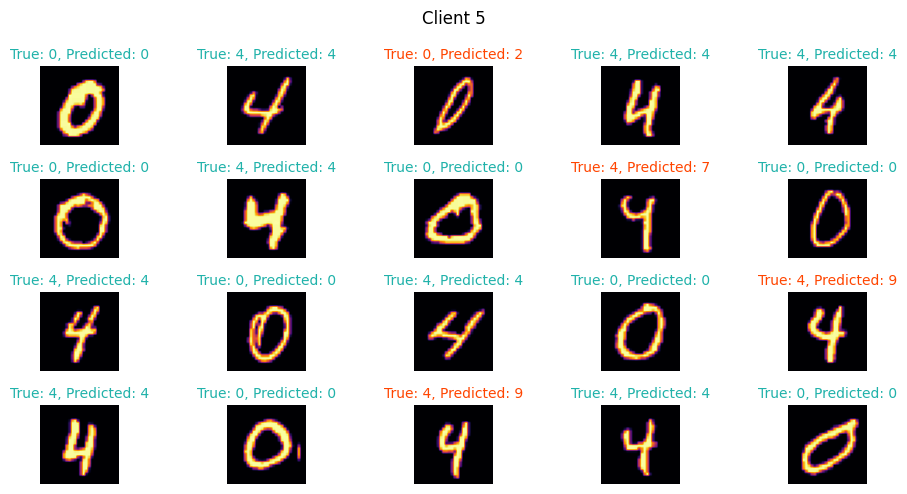

In [18]:
for client_number in range(5):
    plot_test(model_fedprox, test_data[client_number], client_number+1)

# Training using FedSGD
---

In [19]:
n_iter=40
FedSGD = FedSGD(model, train_data, test_data, 2, 0.1)
model_fedsgd, loss_fedsgd, acc_fedsgd = FedSGD.train(n_iter)

Clients' weights: [0.2, 0.214, 0.198, 0.198, 0.19]
Iteration: 1 Server Loss: 2.2787449707984924 Server Test Accuracy: 14.230804597701148
Iteration: 2 Server Loss: 2.276802180767059 Server Test Accuracy: 30.167698758479002
Iteration: 3 Server Loss: 2.2284441037178038 Server Test Accuracy: 27.308395598358267
Iteration: 4 Server Loss: 2.167972550868988 Server Test Accuracy: 26.228458861208445
Iteration: 5 Server Loss: 2.1037402706146238 Server Test Accuracy: 46.26100791942757
Iteration: 6 Server Loss: 2.0069136295318604 Server Test Accuracy: 46.97917145997077
Iteration: 7 Server Loss: 1.819423927783966 Server Test Accuracy: 55.942049084785204
Iteration: 8 Server Loss: 1.590081020832062 Server Test Accuracy: 62.32681244135608
Iteration: 9 Server Loss: 1.4474089875221252 Server Test Accuracy: 70.3630489622709
Iteration: 10 Server Loss: 1.3048921997547152 Server Test Accuracy: 71.07846519963535
Iteration: 11 Server Loss: 1.0698065721988679 Server Test Accuracy: 76.47023420501083
Iteration: 1

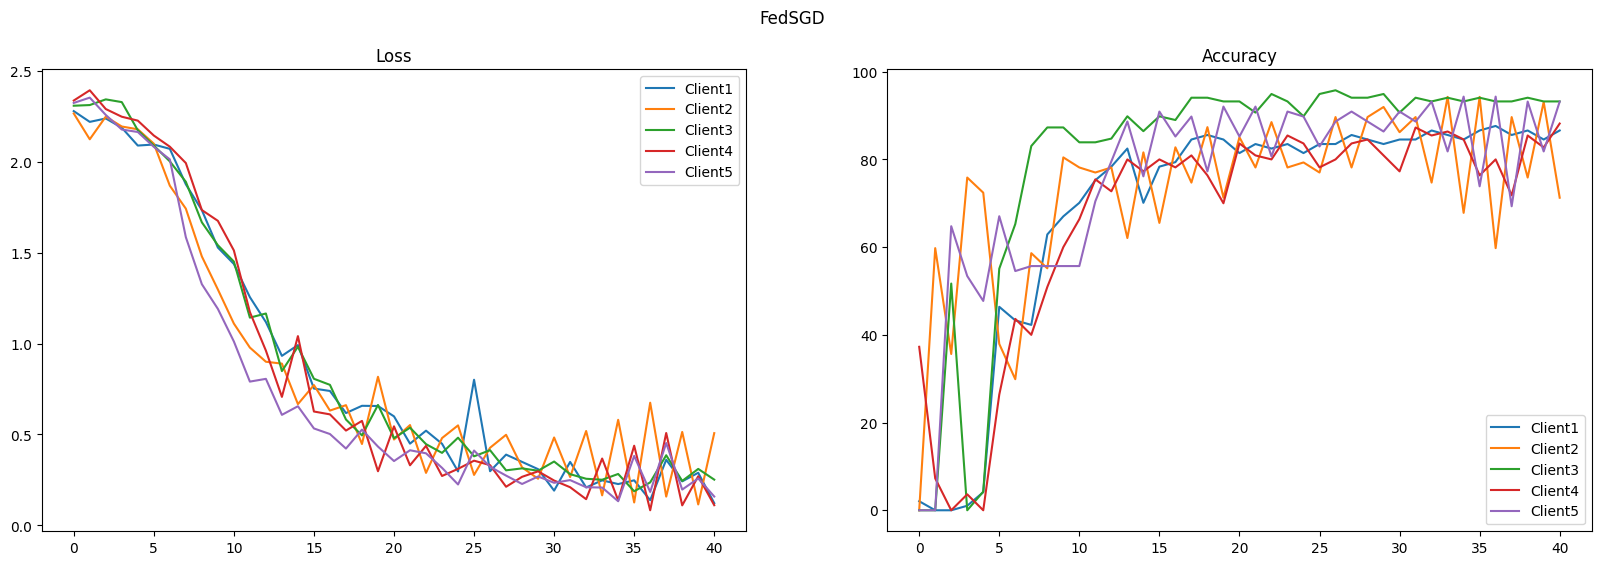

In [20]:
plot("FedSGD", loss_fedsgd, acc_fedsgd)

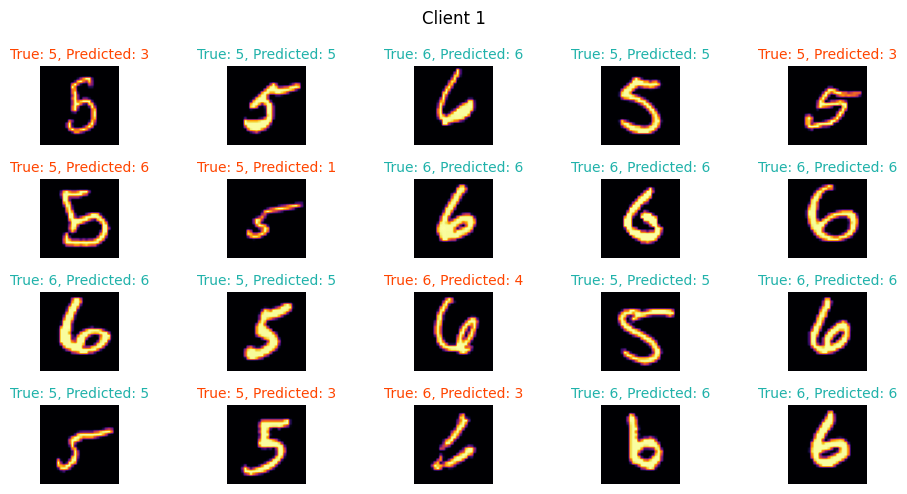

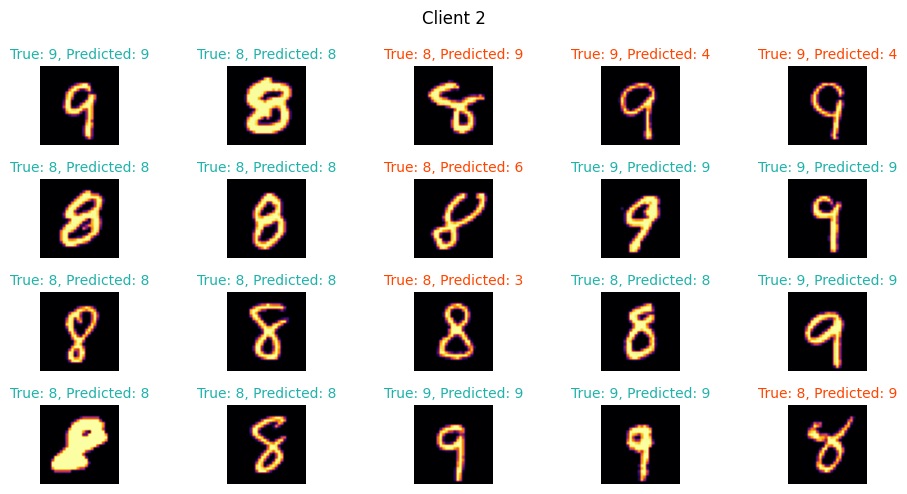

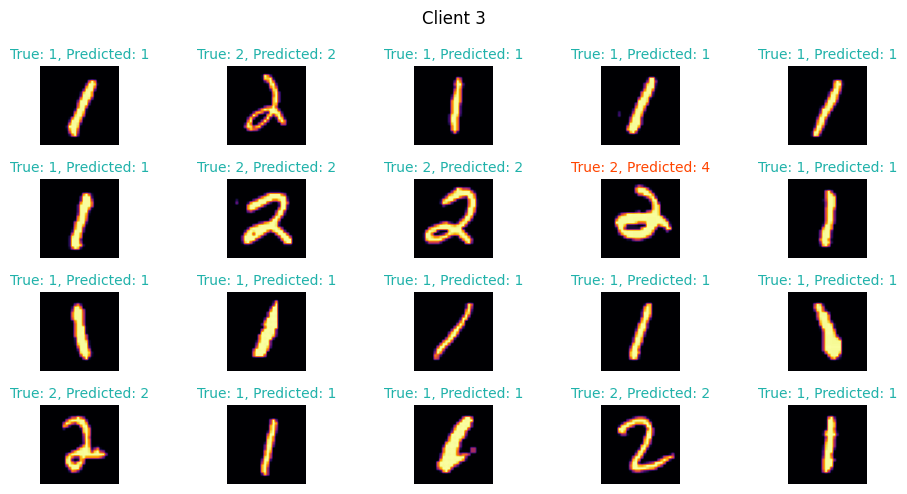

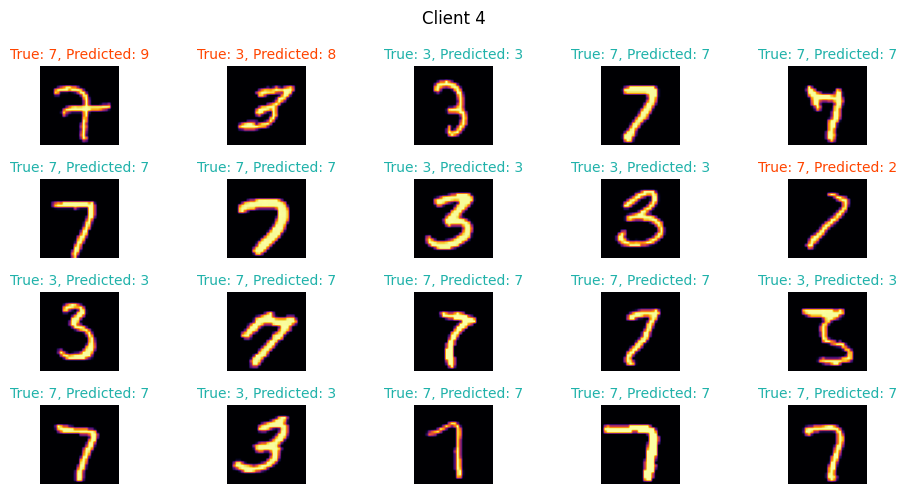

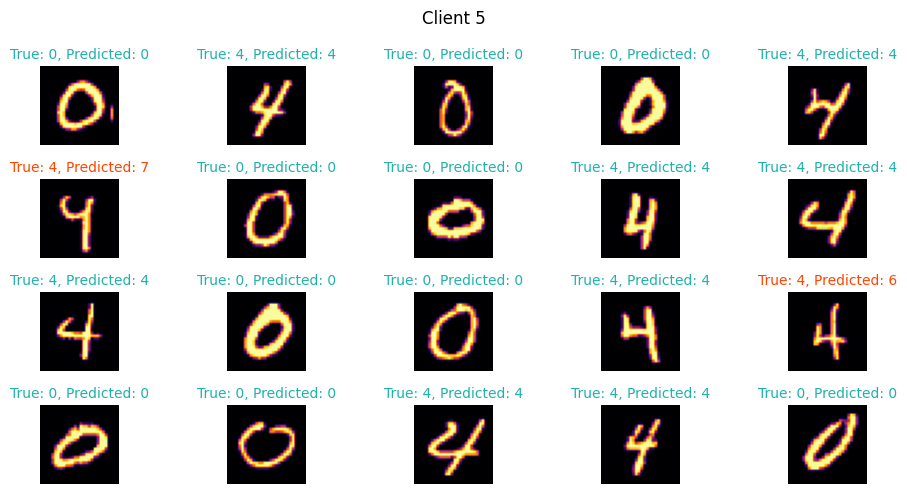

In [21]:
for client_number in range(5):
    plot_test(model_fedsgd, test_data[client_number], client_number+1)